In [199]:
#Imports
import pandas as pd
from pathlib import Path
import tensorflow as tf
import matplotlib.pyplot as plt
import hvplot.pandas
import seaborn as sns
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC


In [200]:
#Read in the CSV files
vehicle_default_loan_df = pd.read_csv(
    Path("Resources/train.csv",
         index_col="date",
                 infer_datetime_format=True,
                 parse_dates=True)
)

# Review the DataFrame
vehicle_default_loan_df.head(4)

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-1984,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-1985,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-1985,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-1993,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1


# Data Cleanup

In [201]:
#CHANGING DATE COLUMNS TO A USABLE FORMAT
vehicle_default_loan_df['DATE_OF_BIRTH'] = pd.to_datetime(vehicle_default_loan_df['DATE_OF_BIRTH'], format='%d-%m-%Y')
vehicle_default_loan_df['DISBURSAL_DATE'] = pd.to_datetime(vehicle_default_loan_df['DISBURSAL_DATE'], format='%d-%m-%Y')


In [202]:
#CHECKING DOB FORMAT
vehicle_default_loan_df.head(1)

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,AVERAGE_ACCT_AGE,CREDIT_HISTORY_LENGTH,NO_OF_INQUIRIES,LOAN_DEFAULT
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [203]:
#CHECKING TO BE SURE THE FORMAT IS UPDATED 
selected_column = 'DISBURSAL_DATE'
selected_data = vehicle_default_loan_df[selected_column]
selected_data.head()

0   2018-08-03
1   2018-09-26
2   2018-08-01
3   2018-10-26
4   2018-09-26
Name: DISBURSAL_DATE, dtype: datetime64[ns]

In [204]:
#CHANGING THE FORMAT OF CREDIT HISTORY LENGTH INTO A USABLE FORMAT. CHANGING FROM 0 YRS 0 MON TO A SINGLE NUMERICAL
#NUMBER THAT REPRESENTS THE TOTAL AMOUNT OF MONTHS 

vehicle_default_loan_df['CH_Years'] = vehicle_default_loan_df['CREDIT_HISTORY_LENGTH'].str.extract(r'(\d+)yrs').astype(int)
vehicle_default_loan_df['CH_Months'] = vehicle_default_loan_df['CREDIT_HISTORY_LENGTH'].str.extract(r'(\d+)mon').astype(int)
vehicle_default_loan_df['Credit_History_Total_Months'] = vehicle_default_loan_df['CH_Years'] * 12 + vehicle_default_loan_df['CH_Months']


In [205]:
#DROPPING EXTRA COLUMNS FROM CH
vehicle_default_loan_df = vehicle_default_loan_df.drop(['CH_Years', 'CH_Months'], axis=1)

In [206]:
#CHANGING FORMAT FOR AVERAGE AGE INTO A USUABLE FORMAT.
vehicle_default_loan_df['Acc_Years'] = vehicle_default_loan_df['AVERAGE_ACCT_AGE'].str.extract(r'(\d+)yrs').astype(int)
vehicle_default_loan_df['Acc_Months'] = vehicle_default_loan_df['AVERAGE_ACCT_AGE'].str.extract(r'(\d+)mon').astype(int)
vehicle_default_loan_df['Average_Acc_Age_Total_Months'] = vehicle_default_loan_df['Acc_Years'] * 12 + vehicle_default_loan_df['Acc_Months']

In [207]:
#DROPPING EXTRA COLUMNS FROM ACC
vehicle_default_loan_df = vehicle_default_loan_df.drop(['Acc_Years', 'Acc_Months'], axis=1)

In [208]:
#DROPPING ORIGINAL AVERAGE_ACCT_AGE AND CREDIT_HISTORY_LENGTH
vehicle_default_loan_df = vehicle_default_loan_df.drop(['AVERAGE_ACCT_AGE', 'CREDIT_HISTORY_LENGTH'], axis=1)

In [209]:
vehicle_default_loan_df.head()

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,LOAN_DEFAULT,Credit_History_Total_Months,Average_Acc_Age_Total_Months
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,...,0,0,0,0,0,0,0,0,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,...,0,0,1991,0,0,1,0,1,23,23
2,417566,53278,61360,89.63,67,22807,45,1497,1985-08-24,Self employed,...,0,0,0,0,0,0,0,0,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,1993-12-30,Self employed,...,0,0,31,0,0,0,1,1,15,8
4,539055,52378,60300,88.39,67,22807,45,1495,1977-12-09,Self employed,...,0,0,0,0,0,0,1,1,0,0


In [210]:

#vehicle_default_loan_df.to_csv('Updated_vehicle_loan.csv', index=False)

In [211]:
vehicle_default_loan_df.columns

Index(['UNIQUEID', 'DISBURSED_AMOUNT', 'ASSET_COST', 'LTV', 'BRANCH_ID',
       'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'DATE_OF_BIRTH',
       'EMPLOYMENT_TYPE', 'DISBURSAL_DATE', 'STATE_ID', 'EMPLOYEE_CODE_ID',
       'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'VOTERID_FLAG',
       'DRIVING_FLAG', 'PASSPORT_FLAG', 'PERFORM_CNS_SCORE',
       'PERFORM_CNS_SCORE_DESCRIPTION', 'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS',
       'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT',
       'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS',
       'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT',
       'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT',
       'NEW_ACCTS_IN_LAST_SIX_MONTHS', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
       'NO_OF_INQUIRIES', 'LOAN_DEFAULT', 'Credit_History_Total_Months',
       'Average_Acc_Age_Total_Months'],
      dtype='object')

In [212]:
#CHECK FOR OBJECTS LEFT IN DF 
vehicle_default_loan_df.dtypes
categorical_variables = list(vehicle_default_loan_df.dtypes[vehicle_default_loan_df.dtypes == "object"].index)
categorical_variables
#Always drop these columns before trying to run model, may have to drop columns with dates as well

['EMPLOYMENT_TYPE', 'PERFORM_CNS_SCORE_DESCRIPTION']

In [213]:
vehicle_default_loan_df.head(2)

,UNIQUEID,DISBURSED_AMOUNT,ASSET_COST,LTV,BRANCH_ID,SUPPLIER_ID,MANUFACTURER_ID,CURRENT_PINCODE_ID,DATE_OF_BIRTH,EMPLOYMENT_TYPE,...,SEC_SANCTIONED_AMOUNT,SEC_DISBURSED_AMOUNT,PRIMARY_INSTAL_AMT,SEC_INSTAL_AMT,NEW_ACCTS_IN_LAST_SIX_MONTHS,DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS,NO_OF_INQUIRIES,LOAN_DEFAULT,Credit_History_Total_Months,Average_Acc_Age_Total_Months
0,420825,50578,58400,89.55,67,22807,45,1441,1984-01-01,Salaried,...,0,0,0,0,0,0,0,0,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,1985-07-31,Self employed,...,0,0,1991,0,0,1,0,1,23,23


In [214]:
vehicle_default_loan_df.dtypes

UNIQUEID                                        int64
DISBURSED_AMOUNT                                int64
ASSET_COST                                      int64
LTV                                           float64
BRANCH_ID                                       int64
SUPPLIER_ID                                     int64
MANUFACTURER_ID                                 int64
CURRENT_PINCODE_ID                              int64
DATE_OF_BIRTH                          datetime64[ns]
EMPLOYMENT_TYPE                                object
DISBURSAL_DATE                         datetime64[ns]
STATE_ID                                        int64
EMPLOYEE_CODE_ID                                int64
MOBILENO_AVL_FLAG                               int64
AADHAR_FLAG                                     int64
PAN_FLAG                                        int64
VOTERID_FLAG                                    int64
DRIVING_FLAG                                    int64
PASSPORT_FLAG               

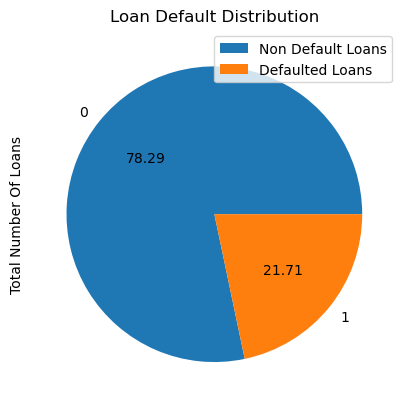

In [215]:
vehicle_default_loan_df['LOAN_DEFAULT'].value_counts().plot(kind="pie", autopct="%.2f", title="Loan Default Distribution", xlabel="Non Default Loan", ylabel="Total Number Of Loans")
plt.legend(["Non Default Loans", "Defaulted Loans"], loc="upper right")
plt.show()

<Axes: title={'center': 'CNS Description Distribution'}, ylabel='Total Number Of Loans'>

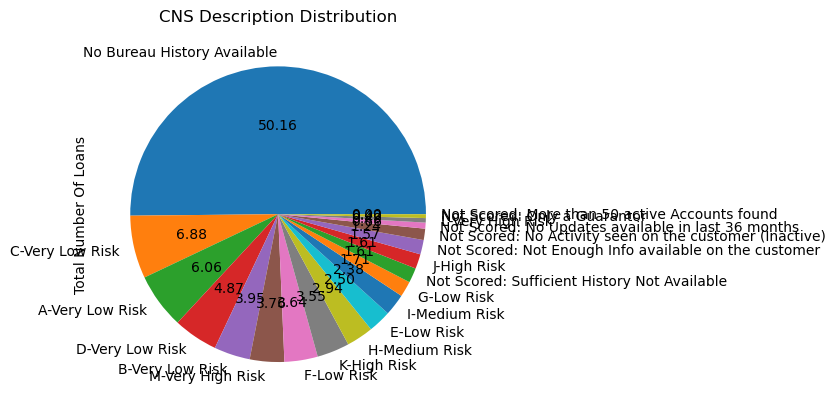

In [216]:
vehicle_default_loan_df['PERFORM_CNS_SCORE_DESCRIPTION'].value_counts().plot(kind="pie", autopct="%.2f", title="CNS Description Distribution", xlabel="Non Default Loan", ylabel="Total Number Of Loans", fontsize=10,)


Text(0, 0.5, 'Number of Customers')

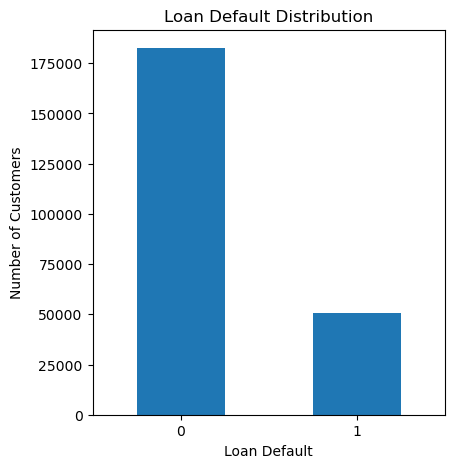

In [217]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
vehicle_default_loan_df['LOAN_DEFAULT'].value_counts().plot(kind='bar', rot=0)
plt.title('Loan Default Distribution')
plt.xlabel('Loan Default')
plt.ylabel('Number of Customers')

# LOGISTIC REGRESSION MODELS USING ALL OF THE INFORMATION 

In [218]:
vehicle_default_loan_df_1 = vehicle_default_loan_df.drop(["DISBURSAL_DATE","DATE_OF_BIRTH","EMPLOYMENT_TYPE","PERFORM_CNS_SCORE_DESCRIPTION"], axis=1)

In [219]:
#CREATING LOGISTIC REGRESSION MODEL
y = vehicle_default_loan_df_1["LOAN_DEFAULT"]
X = vehicle_default_loan_df_1.drop(columns="LOAN_DEFAULT")

In [220]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [221]:
logistic_regression_model = LogisticRegression(random_state=9)

In [222]:
lr_model_1 = logistic_regression_model.fit(X_train, y_train)

c:\Users\Mike Red\.conda\envs\mlenv2\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [223]:
training_predictions = lr_model_1.predict(X_train)
testing_predictions = logistic_regression_model.predict(X_test)

In [224]:
training_matrix_1 = confusion_matrix(y_train, training_predictions)
print(training_matrix_1)

[[136856     10]
 [ 37995      4]]


In [225]:
test_matrix_1 = confusion_matrix(y_test, testing_predictions)
print(test_matrix_1)

[[45676     1]
 [12612     0]]


In [226]:
training_report_1 = classification_report(y_train, training_predictions)
print(training_report_1)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88    136866
           1       0.29      0.00      0.00     37999

    accuracy                           0.78    174865
   macro avg       0.53      0.50      0.44    174865
weighted avg       0.67      0.78      0.69    174865



In [227]:
# Create and save the testing classifiction report
testing_report_1 = classification_report(y_test, testing_predictions)

# Print the testing classification report
print(testing_report_1)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     45677
           1       0.00      0.00      0.00     12612

    accuracy                           0.78     58289
   macro avg       0.39      0.50      0.44     58289
weighted avg       0.61      0.78      0.69     58289



Accuracy score is 78 percent which is pretty good to start, I will start to try to focus on specifc variables to try to increase accuracy. 

# LOGISTIC REGRESSION MODELS USING BUREAU DATA AND HISTORY (BUREAU SCORE, NUMBER OF ACTIVE ACCOUNTS,CREDIT HISTORY,ETC)

In [228]:
vehicle_default_loan_df_2 = vehicle_default_loan_df.drop(['UNIQUEID', 'ASSET_COST', 'LTV', 'BRANCH_ID',
       'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'STATE_ID',
       'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG',
       'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG',
       ], axis=1)

In [229]:
vehicle_default_loan_df_2.columns

Index(['DISBURSED_AMOUNT', 'DATE_OF_BIRTH', 'EMPLOYMENT_TYPE',
       'DISBURSAL_DATE', 'PERFORM_CNS_SCORE', 'PERFORM_CNS_SCORE_DESCRIPTION',
       'PRI_NO_OF_ACCTS', 'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS',
       'PRI_CURRENT_BALANCE', 'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT',
       'SEC_NO_OF_ACCTS', 'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS',
       'SEC_CURRENT_BALANCE', 'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT',
       'PRIMARY_INSTAL_AMT', 'SEC_INSTAL_AMT', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
       'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS', 'NO_OF_INQUIRIES',
       'LOAN_DEFAULT', 'Credit_History_Total_Months',
       'Average_Acc_Age_Total_Months'],
      dtype='object')

In [230]:
y = vehicle_default_loan_df_1["LOAN_DEFAULT"]
X = vehicle_default_loan_df_1.drop(columns="LOAN_DEFAULT")

In [231]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [232]:
logistic_regression_model = LogisticRegression(random_state=9)

In [233]:
lr_model_2 = logistic_regression_model.fit(X_train, y_train)

c:\Users\Mike Red\.conda\envs\mlenv2\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [234]:
training_predictions_2 = lr_model_2.predict(X_train)
testing_predictions_2 = logistic_regression_model.predict(X_test)

In [235]:
training_matrix_2 = confusion_matrix(y_train, training_predictions_2)
print(training_matrix_2)

[[136987      4]
 [ 37873      1]]


In [236]:
test_matrix_2 = confusion_matrix(y_test, testing_predictions_2)
print(test_matrix_2)

[[45552     0]
 [12737     0]]


In [237]:
training_report_2 = classification_report(y_train, training_predictions_2)
print(training_report_2)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88    136991
           1       0.20      0.00      0.00     37874

    accuracy                           0.78    174865
   macro avg       0.49      0.50      0.44    174865
weighted avg       0.66      0.78      0.69    174865



In [238]:
# Create and save the testing classifiction report
testing_report_2 = classification_report(y_test, testing_predictions_2)

# Print the testing classification report
print(testing_report_2)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88     45552
           1       0.00      0.00      0.00     12737

    accuracy                           0.78     58289
   macro avg       0.39      0.50      0.44     58289
weighted avg       0.61      0.78      0.69     58289



c:\Users\Mike Red\.conda\envs\mlenv2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mike Red\.conda\envs\mlenv2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mike Red\.conda\envs\mlenv2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model perfomed signficantly worse in (1) , by taking away the information the precision dropped to 0

# LOGISTIC REGRESSION MODELS USING BUREAU DATA AND HISTORY (OTHERS)

In [239]:
vehicle_default_loan_df_2 = vehicle_default_loan_df.drop(['UNIQUEID', 'ASSET_COST', 'LTV', 'BRANCH_ID',
       'SUPPLIER_ID', 'MANUFACTURER_ID', 'CURRENT_PINCODE_ID', 'STATE_ID', 'DISBURSAL_DATE', 
       'EMPLOYEE_CODE_ID', 'MOBILENO_AVL_FLAG', 'AADHAR_FLAG', 'PAN_FLAG', 'PERFORM_CNS_SCORE_DESCRIPTION',
       'VOTERID_FLAG', 'DRIVING_FLAG', 'PASSPORT_FLAG', 'DATE_OF_BIRTH', 'EMPLOYMENT_TYPE', 'NEW_ACCTS_IN_LAST_SIX_MONTHS',
       'NO_OF_INQUIRIES', 'Credit_History_Total_Months', 
       'Average_Acc_Age_Total_Months'
       ], axis=1)

In [240]:
vehicle_default_loan_df_2.columns

Index(['DISBURSED_AMOUNT', 'PERFORM_CNS_SCORE', 'PRI_NO_OF_ACCTS',
       'PRI_ACTIVE_ACCTS', 'PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE',
       'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'SEC_NO_OF_ACCTS',
       'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',
       'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT',
       'SEC_INSTAL_AMT', 'DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS',
       'LOAN_DEFAULT'],
      dtype='object')

In [241]:
y = vehicle_default_loan_df_1["LOAN_DEFAULT"]
X = vehicle_default_loan_df_1.drop(columns="LOAN_DEFAULT")

In [242]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [243]:
logistic_regression_model = LogisticRegression(random_state=9)

In [244]:
lr_model_3 = logistic_regression_model.fit(X_train, y_train)

c:\Users\Mike Red\.conda\envs\mlenv2\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [245]:
training_predictions_3 = lr_model_3.predict(X_train)
testing_predictions_3 = logistic_regression_model.predict(X_test)

In [246]:
training_matrix_3 = confusion_matrix(y_train, training_predictions_3)
print(training_matrix_3)

[[136760     12]
 [ 38091      2]]


In [247]:
test_matrix_3 = confusion_matrix(y_test, testing_predictions_3)
print(test_matrix_3)

[[45766     5]
 [12517     1]]


In [248]:
training_report_3 = classification_report(y_train, training_predictions_3)
print(training_report_3)

              precision    recall  f1-score   support

           0       0.78      1.00      0.88    136772
           1       0.14      0.00      0.00     38093

    accuracy                           0.78    174865
   macro avg       0.46      0.50      0.44    174865
weighted avg       0.64      0.78      0.69    174865



In [249]:
# Create and save the testing classifiction report
testing_report_3 = classification_report(y_test, testing_predictions_3)

# Print the testing classification report
print(testing_report_3)

              precision    recall  f1-score   support

           0       0.79      1.00      0.88     45771
           1       0.17      0.00      0.00     12518

    accuracy                           0.79     58289
   macro avg       0.48      0.50      0.44     58289
weighted avg       0.65      0.79      0.69     58289

